# Generative Adversarial Network (GAN) {-}

This notebook aims at familiarizing you with training, validating and testing a Generative Adversarial Network (GAN). Here are the requirements:

- Load the dataset. To save training time, you only need to load and work on ONE image class of your choice.
- Process the images.
- Build a GAN architecture consisting of at least one (01) Discriminator and one (01) Generator of which the architectures are of your choice. There are two levels of image generation requirements:
    - First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN. 
    - Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN. 
- Visualize the model behaviors during the training.
- Visualize the generated images.

The dataset you will be working on is CIFAR-10. This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

# Second-level requirement
Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN.

# Library and data importation

In [1]:
!pip install tensorflow_datasets

In [2]:
# Import libraries
import os
import numpy as np
from numpy import zeros, ones, vstack, expand_dims
from numpy.random import randn, randint
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import callbacks, optimizers, Sequential, Model
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, UpSampling2D, Conv2DTranspose, LeakyReLU, Conv2D, Reshape
from keras.utils import np_utils
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Build the GAN with Generator & Discriminator

In [3]:
def define_generator(latent_dim):
    model = Sequential()

    # Initial shape: 4x4x256
    model.add(Dense(4*4*256, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 8x8x128
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 16x16x64
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 32x32x32
    model.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer: 32x32x3
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

    return model

In [4]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [5]:
def define_gan(g_model, d_model):
    # Make the Discriminator layers non-trainable
    d_model.trainable = False

    # Combine Generator and Discriminator
    model = Sequential()

    # Add Generator
    model.add(g_model)

    # Add Discriminator
    model.add(d_model)

    return model

## Prepare real data samples from dataset

In [6]:
def load_real_samples():
    (trainX, trainY), (_, _) = tf.keras.datasets.cifar10.load_data()
    # Select only the images with label "8" (ship)
    indices = np.where(trainY == 8)[0]
    X = trainX[indices].astype('float32')
    X = (X - 127.5) / 127.5  # Normalize to [-1, 1]
    return X

def generate_real_samples(dataset, n_samples):
    # Select random indices for sampling
    indices = np.random.randint(0, dataset.shape[0], n_samples)

    # Retrieve the selected real samples
    X = dataset[indices]

    # Generate corresponding labels (1 for real samples)
    y = np.ones((n_samples, 1))

    return X, y

## Generate fake data samples by passing a random vector through the Generator

In [7]:
# Generate random latent vectors as input for Generator
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape to a batch of inputs for the Generator
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    # Generate latent points as input for the Generator
    latent_points = generate_latent_points(latent_dim, n_samples)

    # Generate fake samples using the Generator
    X_fake = g_model.predict(latent_points)

    # Generate corresponding labels (0 for fake samples)
    y_fake = np.zeros((n_samples, 1))

    return X_fake, y_fake

## Training process with the Generator and the Discriminator

In [8]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    d_losses = []
    g_losses = []

    for epoch in range(n_epochs):
        for batch in range(batch_per_epoch):
            # Update Discriminator weights
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real = d_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake = d_model.train_on_batch(X_fake, y_fake)

            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Update Generator weights
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Append losses to the lists
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            # Print the progress
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch+1}/{batch_per_epoch}, D_loss={d_loss:.4f}, G_loss={g_loss:.4f}")
        # Plot the generated images every certain number of epochs
        if (epoch+1) % 10 == 0:
            X_fake, _ = generate_fake_samples(g_model, latent_dim, 100) # Generate 100 fake data samples using the Generator. Pixel values are in [0,1]
            save_plot(X_fake, epoch, n=10) # Plot a grid of 10x10 fake samples and save to file at epoch i
    return d_losses, g_losses

## Plot the Generator's output

In [9]:
# Define the directory path for saving generated images
save_dir = '/content/generated_images'

# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # Create directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Define a plot of (n rows, n columns)
    for i in range(n * n):
        # (1+i) is the index position on a grid with nrows rows and ncols columns. Index starts at 1 in the upper left corner and increases to the right.
        pyplot.subplot(n, n, 1+i)
        pyplot.axis('off') # Disable axis
        pyplot.imshow(samples[i, :, :, 0], cmap='gray_r') # Plot the sample i with reversed gay color map
    filename = f'Plot_epoch_{epoch+1:03d}.png'
    filepath = os.path.join(save_dir, filename)
    pyplot.savefig(filepath) # Save plot to file
    pyplot.close() # Close the plot

In [10]:
def visualize_images(g_model, latent_dim, n_samples=25):
    # Generate fake samples using the Generator
    X_fake, _ = generate_fake_samples(g_model, latent_dim, n_samples)

    # Rescale pixel values from [-1, 1] to [0, 1]
    X_fake = (X_fake + 1) / 2.0

    # Create a grid of generated images
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(n_samples):
        axs[i].imshow(X_fake[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Main code

In [11]:
# Define the size of the latent space (latent_dim), number of epochs, and batch size
latent_dim = 128
epochs = 250
batch_size = 64

# Initialize an optimizer (Adam)
optimizer = Adam(lr=0.0002, beta_1=0.5)

# Create the discriminator
d_model = define_discriminator()
d_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Create the generator
g_model = define_generator(latent_dim)

# Create the GAN
gan_model = define_gan(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=optimizer)

# Load real image data using load_real_samples()
dataset = load_real_samples()

# Train the GAN
d_losses, g_losses = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, batch_size)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
Epoch 218/250, Batch 77/78, D_loss=0.4961, G_loss=1.5596
1/1 [==============================] - 0s 18ms/step
Epoch 218/250, Batch 78/78, D_loss=0.4901, G_loss=1.4797
1/1 [==============================] - 0s 19ms/step
Epoch 219/250, Batch 1/78, D_loss=0.4231, G_loss=1.4965
1/1 [==============================] - 0s 19ms/step
Epoch 219/250, Batch 2/78, D_loss=0.4291, G_loss=1.4688
1/1 [==============================] - 0s 18ms/step
Epoch 219/250, Batch 3/78, D_loss=0.4549, G_loss=1.4887
1/1 [==============================] - 0s 19ms/step
Epoch 219/250, Batch 4/78, D_loss=0.3556, G_loss=1.6851
1/1 [==============================] - 0s 19ms/step
Epoch 219/250, Batch 5/78, D_loss=0.5087, G_loss=1.4692
1/1 [==============================] - 0s 18ms/step
Epoch 219/250, Batch 6/78, D_loss=0.4805, G_loss=1.3386
1/1 [==============================] - 0s 18ms/step
Epoch 219/250, Batch 7/78, D_loss=0.4842, G_loss=1.4643
1/1 [======================

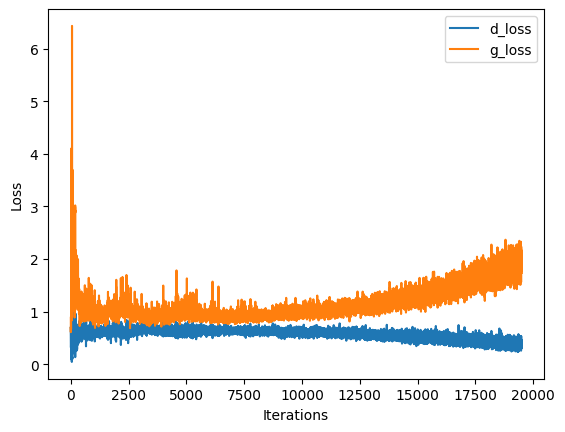

In [12]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

## Save and load the model

In [13]:
# Save the Discriminator, Generator and GAN model
d_model.save('d_model.sav')
g_model.save('g_model.sav')
gan_model.save('gan_model.sav')

4/4 [==============================] - 0s 2ms/step


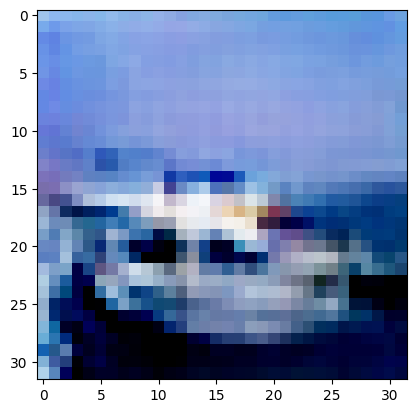

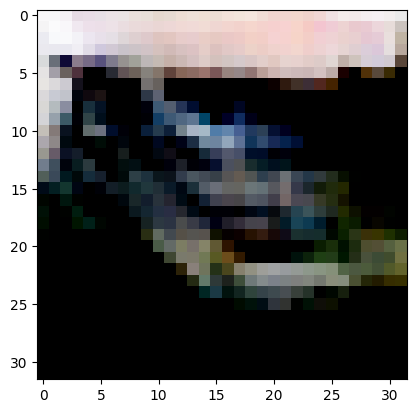

In [18]:
# Load the Generator from saved model
g_model = keras.models.load_model("g_model.sav")

# Generate 100 fake images by passing 100-dimensional random vectors through the Generator.
X_fake, _ = generate_fake_samples(g_model, 128, 100)

# Visualize the generated images
imgplot = plt.imshow(X_fake[5])
plt.show()
imgplot = plt.imshow(X_fake[10])
plt.show()

1/1 [==============================] - 0s 104ms/step


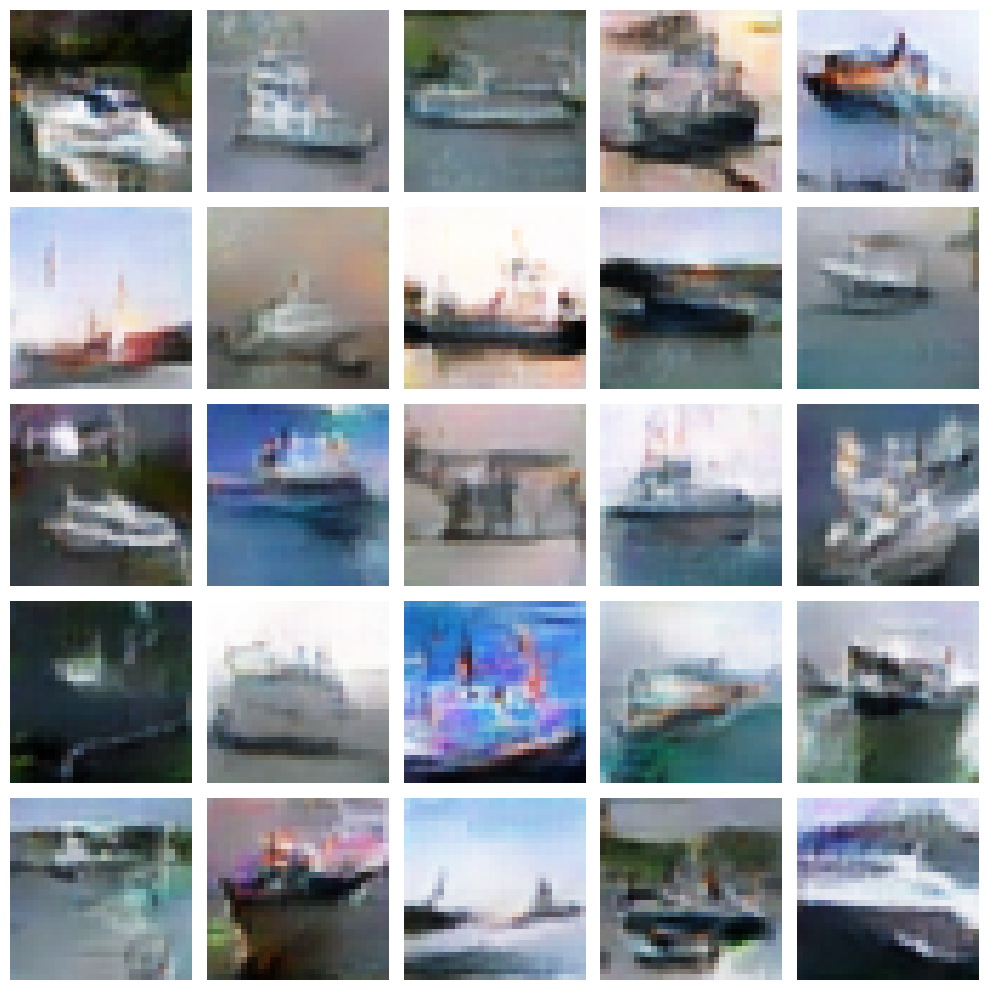

In [15]:
visualize_images(g_model, latent_dim, n_samples=25)